In [15]:
%config Completer.use_jedi = False

In [789]:
from utils import *
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import geoplot as gplt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

dataset = "../datasets/UK50_1.txt"
meta_data, distance_data, station_data = parse_UK_Data(dataset)

#station_coordinates = generate_coordinates(station_data, to_csv=True, filename=dataset)
location_context = "United Kingdom"
#station_coordinates = generate_coordinates(station_data,location_context)
station_coordinates = pd.read_csv('../datasets/UK50_1_coordinates.csv', encoding='utf-8')
points_coordinate = station_coordinates[["lat", "lng"]].to_numpy()

#UK = gpd.read_file("../datasets/united_kingdom_european_regions/Regions__December_2019__Boundaries_EN_BFC-shp/Regions__December_2019__Boundaries_EN_BFC.shp")
dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
dbf = dbf.to_crs("EPSG:4326")

In [797]:
station_data

,City Name,Demand(kg),Ready Time(sec),Due Time(sec),Service Time(sec)
0,Burgess_Hill,0,0,32400,0
1,South_Ockendon,561,1496,20780,1122
2,Chorleywood,605,2654,22842,1210
3,Crowborough,365,4649,24733,730
4,Saint_Albans,263,2787,22861,526
5,Strood,753,2889,22820,1506
6,Radlett,663,4991,26010,1326
7,Tadley,102,3934,22643,204
8,Slough,290,4823,23559,580
9,Dartford,517,2258,22703,1034


In [798]:
sum(station_data["Demand(kg)"].astype(int))/10

2312.6

In [799]:

def demand_callback(from_node,demands):
    """Returns the demand of the node."""
    # Convert from routing variable Index to demands NodeIndex.
   # from_node = manager.IndexToNode(from_index)
    return demands[from_node]

# Create and register a transit callback.
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

def fuel_consumption_callback(from_node, to_node,distance_matrix,demands):

    """Returns the estimated fuel consumption between two nodes.
    Based on 'A Fuel Consumption Objective of VRP and the Genetic Algorithm' by Hao Xiong"""

    #Distance in 100km
    distance = (distance_matrix[from_node][to_node])/1e5
    #Demand in kg
    demand = demands[from_node]
    #Fuel consumption between nodes driving empty vehicle
    fuel_consumption_empty = distance * meta_data['F-C Empty (l/100km)']
    load_rate = demand / float(meta_data['Max Load(kg)'])
    #Additional fuel consumption when adding load at from_index
    fuel_consumption_load = distance * load_rate * (meta_data['F-C Full (l/100km)'] - meta_data['F-C Empty (l/100km)'])
    return np.float(fuel_consumption_empty + fuel_consumption_load)
    
    


In [809]:
import math
import random
from jmetal.core.problem import PermutationProblem
from jmetal.core.solution import PermutationSolution

class VRP(PermutationProblem):
    
    def __init__(self,problemData):
        check_type(problemData,dict)
        super(VRP,self).__init__()
        
        self.distance_matrix = problemData['distance_matrix']
        self.demands = problemData['demands']
        self.max_no_of_vehicle = problemData['vehicle_amount']
        self.vehicle_capacities = problemData['vehicle_capacities']
        self.object_directions=[self.MINIMIZE]
        self.number_of_objectives = problemData['objective_amount']
        self.objective_functions=problemData['objective_functions']
        self.objective_labels = problemData['objective_labels']
        self.number_of_constraints = problemData['constraint_amount']
        self.constraint_functions= problemData['constraint_functions']
        self.number_of_variables = problemData['number_of_cities']
        self.start_positions = problemData['start_points']
        self.end_positions = problemData['end_points']
        self.depot = 0
        self.cost_history = []

    
    def evaluate(self, solution: PermutationSolution) -> PermutationSolution:
        fitness = 0
        permutation = solution.variables
        capacity = self.vehicle_capacities[0]
        # Start positions = [0,6] -> paths = [[0],[6]]
        paths = [[x] for x in self.start_positions]
        vehicles = 1
        solution.number_of_objectives = 1
        current_load = 0
        vehicle_index=0
        for node_index in permutation:
            if not node_index in self.start_positions:
                load = current_load + demand_callback(node_index,self.demands)

                if load <= capacity:
                    paths[vehicle_index].append(node_index)
                    current_load = load

                else:
                    if vehicle_index +1 == self.max_no_of_vehicle:
                        print("COULD NOT WITHOLD LOAD CONSTRAINT")
                        break
                        
                    vehicles +=1
                    vehicle_index+=1
                    current_load = 0
                    paths[vehicle_index].append(node_index)

        solution.vehicle_loads = []
        for vehicle_route in paths:
            vehicle_load = 0
            for node_index in range(len(vehicle_route)-1):
                from_node = vehicle_route[node_index]
                to_node = vehicle_route[node_index + 1]
                
                vehicle_load += demand_callback(from_node,self.demands)
                
                fitness += fuel_consumption_callback(from_node=from_node,to_node=to_node,distance_matrix=self.distance_matrix,demands=self.demands)
                #fitness += self.distance_matrix[from_node][to_node]
            solution.vehicle_loads.append(vehicle_load)
                
        self.cost_history.append(fitness)
        solution.objectives[0] = fitness
        solution.path=paths
        
        return solution
    
    def get_route(self, solution: PermutationSolution) -> PermutationSolution:
        routes = []
        for index in range(len(solution.path) - 1):
            if solution.path[index] == 0 :
                routes.append([0])
            else:
                routes[-1].append(solution.path[index])
                

        return routes
    
    def create_solution(self) -> PermutationSolution:
        new_solution = PermutationSolution(number_of_variables=self.number_of_variables,number_of_objectives=self.number_of_objectives)
        new_solution.variables = random.sample(range(self.number_of_variables), k=self.number_of_variables)
        return new_solution
        
    def get_name(self):
        return 'VRP'

In [810]:
meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
distance_matrix_here,_ = generate_large_distance_matrix(points_coordinate,api)

In [811]:
distance_matrix_here

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0,92554,111288,36039,128068,98432,132246,135438,98760,82694,...,142419,22300,19545,123434,89065,103377,89858,183142,28230,101205
1,91831,0,90102,64266,71435,31217,73317,144290,108291,13508,...,200097,69679,105788,132286,160971,106910,32902,136717,76585,110057
2,111591,82943,0,124825,21875,107178,26053,88467,33009,89469,...,145301,89439,125548,76463,127441,22278,47562,59970,114221,54234
3,35993,64236,139677,0,124167,70114,124565,147215,114595,54376,...,170662,39966,42594,135211,118335,115154,82614,194919,12997,112982
4,128266,70129,21764,124099,0,91050,8406,105142,41626,73341,...,161976,106114,142223,93138,144116,38953,41277,70379,136418,70909
5,100382,34253,111367,72817,92700,0,94582,152841,116163,24847,...,222876,78230,114339,140837,169522,128175,53056,157982,85136,118608
6,126380,71089,19878,128373,8502,95324,0,103256,39740,77615,...,160090,104228,140337,91252,142230,37067,36278,71328,140692,69023
7,135639,144421,87198,148873,103978,150299,108156,0,56054,134561,...,86304,113487,149596,15240,91232,79287,94102,107260,138269,41105
8,98652,107434,30908,111886,44531,113312,43643,54496,0,97574,...,131335,76500,112609,63524,114502,9332,34804,91949,101282,41295
9,82899,14042,91156,55334,73973,22352,74371,135358,98680,0,...,205393,60747,96856,123354,152039,107964,31045,137771,67653,101125


In [823]:

starts =[0,0,4,4,6,6,20,20]
vehicle_amount = len(starts)

customer_demands = station_data.T.loc["Demand(kg)"].astype(int).to_numpy()
customer_demands[starts] = 0
#customer_demands[ends] = 0
customer_demands = customer_demands.tolist()

vehicle_capacities = [meta_data['Max Load(kg)'].astype(int)[0] for x in range(vehicle_amount)]


distance_matrix = make_open_problem(distance_matrix_here,starts)

#distance_matrix = make_open_problem(squareform(pdist(points_coordinate)),starts)

#depot = 0


data_model_input = {'distance_matrix':distance_matrix,'vehicle_amount':vehicle_amount,
                   'demands':customer_demands,'vehicle_capacities':vehicle_capacities,
                    'objective_amount':1,'objective_labels':['Distance'],'constraint_amount':1,
                    'objective_functions':[],'constraint_functions':[],
                    'number_of_cities':distance_matrix.shape[0],
                    'start_points':starts,'end_points':[0]}



# data_model_input = {'distance_matrix':distance_matrix,'vehicle_amount':vehicle_amount,
#                    'customer_demands':customer_demands,'vehicle_capacities':vehicle_capacities,'depot':depot}


In [837]:
from jmetal.algorithm.multiobjective.nsgaii import NSGAII
from jmetal.algorithm.singleobjective import SimulatedAnnealing,GeneticAlgorithm
from jmetal.operator.crossover import PMXCrossover
from jmetal.operator.selection import Selection
from jmetal.operator import BinaryTournamentSelection, PolynomialMutation, SBXCrossover, RandomSolutionSelection
from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import SparkEvaluator, MultiprocessEvaluator
problem = VRP(data_model_input)
max_evaluations = 10000

# algorithm = SimulatedAnnealing(problem=problem,
#                                mutation=PermutationSwapMutation(0.05),
#                                termination_criterion=StoppingByEvaluations(max_evaluations))
algorithm = GeneticAlgorithm( problem=problem,
        population_size=100,
        offspring_population_size=100,
        mutation=PermutationSwapMutation(1.0 / problem.number_of_variables),
        crossover=PMXCrossover(0.9),
        selection=BinaryTournamentSelection(),
        termination_criterion=StoppingByEvaluations(max_evaluations=5000),
        population_evaluator=MultiprocessEvaluator()
        )

algorithm.run()
solutions = algorithm.get_result()
observable_data = algorithm.get_observable_data()

In [839]:
observable_data

{'PROBLEM': <__main__.VRP at 0x7f35f5bccca0>,
 'EVALUATIONS': 5000,
 'SOLUTIONS': <jmetal.core.solution.PermutationSolution at 0x7f35f64357f0>,
 'COMPUTING_TIME': 18.21651315689087}

In [830]:
observable_data = algorithm.get_observable_data()
observable_data

{'PROBLEM': <__main__.VRP at 0x7f35f47ba130>,
 'EVALUATIONS': 5000,
 'SOLUTIONS': <jmetal.core.solution.PermutationSolution at 0x7f35f5b46340>,
 'COMPUTING_TIME': 133.44058895111084}

[237.70577444520552]
[2603, 3484, 3918, 3860, 3122, 1608, 0, 0]


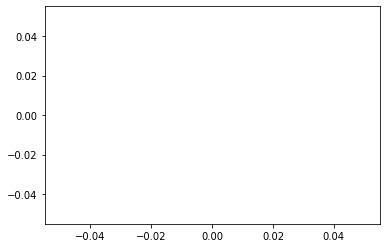

In [836]:
from operator import itemgetter
print(solutions.objectives)
print(solutions.vehicle_loads)
plt.plot(problem.cost_history)
plt.show()

In [826]:
solutions.path

[[0, 34, 21, 13, 50, 37, 7, 24, 27],
 [0, 44, 26, 29, 38, 19, 3],
 [4, 5, 32, 1, 33, 8, 2, 48, 31, 12],
 [4, 47, 16, 25, 14, 46, 42, 23, 10, 43, 22],
 [6, 15, 9, 28, 30, 39, 49, 40, 18, 11],
 [6, 35, 41, 36, 45, 17],
 [20],
 [20]]

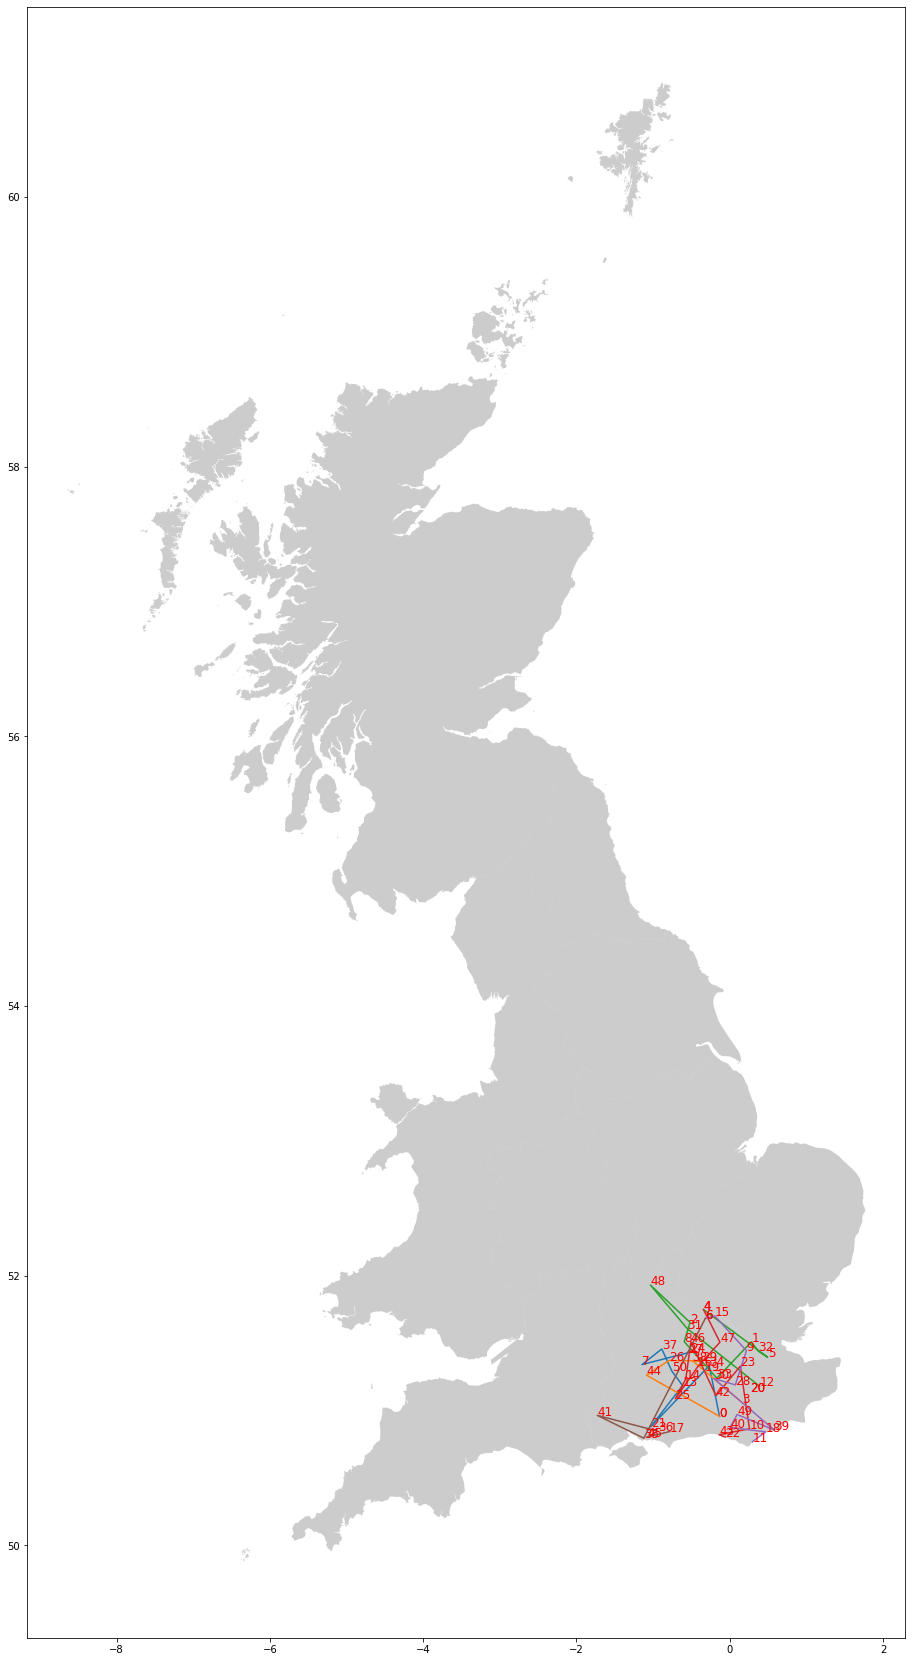

In [827]:
plot_routes(solutions.path,points_coordinate,dbf,station_ids = True, here_api=False, api_key=api)

In [774]:
vehicle_routes = []
vehicle_stops = []
for v_route in solutions.path:
    vehicle_stops.append(points_coordinate[v_route])
    vehicle_routes.append(decode_routes(generate_routes(points_coordinate[v_route],api)))

100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


In [775]:
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
m_1 = folium.Map(location=points_coordinate[0], tiles='openstreetmap', zoom_start=8)
MarkerCluster(points_coordinate).add_to(m_1)

colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
for route,color in zip(vehicle_routes,colors[:len(vehicle_routes)]):
    if(len(route) > 1):
        folium.PolyLine(route,color=color).add_to(m_1)
    
# Display the map
m_1